## 8주차 중간고사

### CNN (Convolution Network)

1. 해당 소스를 이용하여 ML 분류 RF, LR, DT

2. 해당 소스를 이용하여 FCNN

3. 해당 소스를 이용하여 CNN

4. 모든 소스에는 F1값 및 confusion matrix 표시

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [59]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from tensorflow.keras import layers

### 1. Data Load

In [60]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv(url, names=columns)
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [61]:
# 결측치 확인
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [62]:
# 결측치 제거
df = df.dropna()
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [63]:
df['class'].value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [64]:
#레이블을 숫자로 변환
from sklearn.preprocessing import StandardScaler, LabelEncoder

# LabelEncoder 객체 생성
label = LabelEncoder()

# 문자로 지정된 열의 데이터에 대해 LabelEncoder를 적용하여 변환
df['buying'] = label.fit_transform(df['buying'])
df['maint'] = label.fit_transform(df['maint'])
df['doors'] = label.fit_transform(df['doors'])
df['persons'] = label.fit_transform(df['persons'])
df['lug_boot'] = label.fit_transform(df['lug_boot'])
df['safety'] = label.fit_transform(df['safety'])
df['class'] = label.fit_transform(df['class'])

df

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2
...,...,...,...,...,...,...,...
1723,1,1,3,2,1,2,1
1724,1,1,3,2,1,0,3
1725,1,1,3,2,0,1,2
1726,1,1,3,2,0,2,1


### 2. Train Test Split

In [65]:
X=df.drop(['class'], axis=1)

X.head()
# head()는 첫 5행만 출력함.

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2


In [66]:
y = df['class']
y.value_counts().sort_index(ascending=True)

class
0     384
1      69
2    1210
3      65
Name: count, dtype: int64

In [67]:
#one hot encoding 하기

y = pd.get_dummies(y).values
y

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       ...,
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False,  True]])

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# random_state는 데이터를 무작위로 나누거나 섞을 때 사용되는 난수 발생기의 시드(seed) 값
X_train

,buying,maint,doors,persons,lug_boot,safety
520,0,3,3,0,0,2
621,0,0,3,0,2,1
1017,2,0,1,2,2,1
1273,2,1,3,0,1,2
924,2,3,2,0,0,1
...,...,...,...,...,...,...
835,0,1,2,2,0,2
1216,2,1,1,0,2,2
1653,1,1,1,0,0,1
559,0,0,0,2,2,2


In [69]:
X_train.shape[1]

6

In [70]:
y_test.shape[1]

4

In [71]:
def split_sequences(sequences, n_steps, n_features):
    X, y = list(), list()
    for i in range(len(sequences)):
        # 시퀀스의 끝점 계산
        end_ix = i + n_steps
        # 데이터 범위를 넘어서면 중단
        if end_ix > len(sequences):
            break
        # 입력 시퀀스는 n_steps 동안의 데이터 (마지막 레이블 제외)
        seq_x = sequences[i:end_ix, :n_features]
        seq_y = sequences[end_ix-1, n_features:] 
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [72]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
# np.c_ : 배열을 열 방향으로 이어붙인다.
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

print(test_set)

[[1 3 0 ... 0 1 0]
 [3 0 0 ... 0 1 0]
 [0 2 0 ... 0 1 0]
 ...
 [0 2 3 ... 0 0 0]
 [0 2 3 ... 0 1 0]
 [2 0 3 ... 0 0 0]]


In [73]:
# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 5, X_test.shape[1])
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 5, X_test.shape[1])
print(X_test.shape, y_test.shape)

(1292, 5, 6) (1292, 4)
(428, 5, 6) (428, 4)


In [74]:
n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

n_classes

2

In [75]:
# 각각 스텝 수, feature 수, label 수
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

5 6 4


In [76]:
input_shape = X_train.shape[1:]
input_shape

(5, 6)

In [77]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from keras.layers import Dense, Flatten, Dropout

### 3. Make a Model

In [78]:
# 신경망 모델 구축
inputs = Input(shape=(n_timesteps, n_features,))

x = Conv1D(32, 2, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x) # 드롭아웃으로 노드 비활성화
x = Flatten()(x)
prediction = Dense(n_outputs, activation='softmax')(x)

model = Model(inputs=inputs, outputs=prediction)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 6)]            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 32)             416       
                                                                 
 dense_4 (Dense)             (None, 4, 64)             2112      
                                                                 
 dropout_2 (Dropout)         (None, 4, 64)             0         
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 3556 (13.89 KB)
Trainable params: 3556 (13.89

In [79]:
model_history=model.fit(x=X_train, y=y_train, epochs=50, batch_size=32, validation_split = 0.1, shuffle = True)
pred_DL = model.predict(X_test)

y_test_class = np.argmax(y_test,axis=1) # 배열에서 최댓값을 가지는 원소의 인덱스를 반환하는 함수
y_pred_class = np.argmax(pred_DL,axis=1)

Epoch 1/50
37/37 [==============================] - 2s 12ms/step - loss: 0.9631 - accuracy: 0.6497 - val_loss: 0.8554 - val_accuracy: 0.6692
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8465 - accuracy: 0.7074 - val_loss: 0.8370 - val_accuracy: 0.6692
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8321 - accuracy: 0.7108 - val_loss: 0.8073 - val_accuracy: 0.6692
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7939 - accuracy: 0.7108 - val_loss: 0.7780 - val_accuracy: 0.6615
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7532 - accuracy: 0.7194 - val_loss: 0.7471 - val_accuracy: 0.6769
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7419 - accuracy: 0.7238 - val_loss: 0.7307 - val_accuracy: 0.6692
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7202 - accuracy: 0.7160 - val_loss: 0.7180 - val_accuracy: 0.6462
Epoch 8/50
37/37 [=

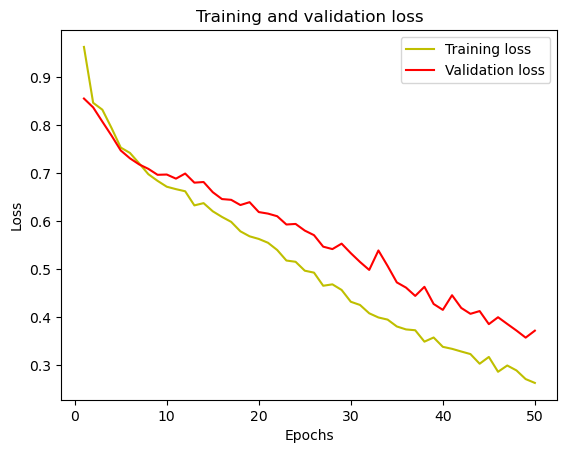

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# 훈련 손실(training loss)과 검증 손실(validation loss) 추출
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# 에포크(epoch) 범위 생성
epochs = range(1, len(loss) + 1)

# 훈련 손실(training loss)과 검증 손실(validation loss) 시각화
plt.plot(epochs, loss, 'y', label='Training loss')  # 훈련 손실을 노란색(yellow)으로 플롯
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 검증 손실을 빨간색(red)으로 플롯
plt.title('Training and validation loss')  # 그래프 제목 설정
plt.xlabel('Epochs')  # x축 레이블 설정
plt.ylabel('Loss')  # y축 레이블 설정
plt.legend()  # 범례(legend) 표시
plt.show()  # 그래프 출력

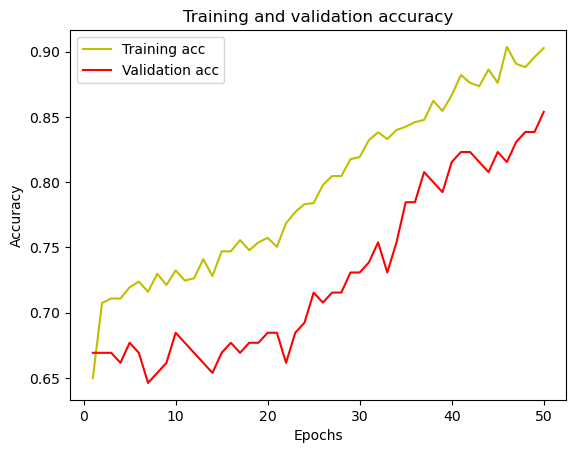

In [81]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class))
print(confusion_matrix(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66        99
           1       0.50      0.05      0.09        21
           2       0.90      0.94      0.92       292
           3       0.71      0.31      0.43        16

    accuracy                           0.82       428
   macro avg       0.68      0.50      0.53       428
weighted avg       0.81      0.82      0.80       428

[[ 70   0  29   0]
 [ 17   1   3   0]
 [ 15   0 275   2]
 [ 10   1   0   5]]
